# Configure Network

## Reference topology

![](pics/topology.png)

## Configure Routers 

__Router 1__

`!---------------------------------------------
conf t
!-----------------------------------------------
! Configuring Interfaces
!-----------------------------------------------
int s1/0
  ip address 12.0.0.1 255.255.255.252
  no sh
  int l0
  ip add 192.168.1.1 255.255.255.0
  int s1/1
  ip add 13.0.0.1 255.255.255.252
  no sh
  int f0/0
  ip add dhcp
  no sh
  exit
!-----------------------------------------------
! Configuring EIGRP AS:100
!-----------------------------------------------
  router eigrp 100
  no auto
  net 0.0.0.0
exit
!-----------------------------------------------
! Configuring SSH 
!-----------------------------------------------
  ip domain name lsbu.com
  username rishi password Pass123..
  crypto key gen rsa mod 1024
  ip ssh ver 2
  line vty 0 15
  transport input ssh
  transport out ssh
  login local
end
wr
`

__Router 2__

`!R2
!---------------------------------------------
conf t
!-----------------------------------------------
! Configuring Interfaces
!-----------------------------------------------
int s1/0
  ip address 12.0.0.2 255.255.255.252
  no sh
  int l0
  ip add 192.168.2.1 255.255.255.0
  int s1/1
  ip add 23.0.0.1 255.255.255.252
  no sh
  int f0/0
  ip add dhcp
  no sh
  exit
!-----------------------------------------------
! Configuring EIGRP AS:100
!-----------------------------------------------
  router eigrp 100
  no auto-summary
  net 0.0.0.0
exit
!-----------------------------------------------
! Configuring SSH 
!-----------------------------------------------
  ip domain name lsbu.com
  username rishi password Pass123..
  crypto key gen rsa mod 1024
  ip ssh ver 2
  line vty 0 15
  transport input ssh
  transport out ssh
  login local
end
wr
`

__Router 3__

`!R3
!---------------------------------------------
conf t
!-----------------------------------------------
! Configuring Interfaces
!-----------------------------------------------
int s1/0
  ip address 23.0.0.2 255.255.255.252
  no sh
  int l0
  ip add 192.168.3.1 255.255.255.0
  int s1/1
  ip add 13.0.0.2 255.255.255.252
  no sh
  int f0/0
  ip add dhcp
  no sh
  exit
!-----------------------------------------------
! Configuring EIGRP AS:100
!-----------------------------------------------
  router eigrp 100
  no auto-summary
  net 0.0.0.0
exit
!-----------------------------------------------
! Configuring SSH 
!-----------------------------------------------
  ip domain name lsbu.com
  username rishi password Pass123..
  crypto key gen rsa mod 1024
  ip ssh ver 2
  line vty 0 15
  transport input ssh
  transport out ssh
  login local
end
wr`

## Enabling SSH Access

To access the routers externally, an SSH connnection is used (similar to OF Channel)

![](pics/topo_ssh.png) 

# Creating a Control plane 

## Step 1 : eshtablish connection

In [3]:
import napalm as npm 

In [4]:
# create a driver 
driver = npm.get_network_driver('ios')

In [373]:
# list of all SSH accessible IP addresses 

def init_param():
    ip_list = ['192.168.182.140', '192.168.182.141', '192.168.182.142']
    uname = 'rishi'
    passwd = 'Pass123..'
    sec = 'cisco123'
    router_obj_list=[]
    # create a routre Object 
    for ip in ip_list:
        router_obj_list.append(driver(hostname=ip, 
                                      username=uname, 
                                      password=passwd,
                                      optional_args={'secret' : 'cisco123'})
                              )
    
    return router_obj_list

def open_conn(router_obj_list):
    for router in router_obj_list:
        router.open()
        temp = router.get_facts()
        print(f"Connection to {temp['vendor']} {temp['model']} Successfull... !")

In [288]:
ro_list = init_param()
open_conn(ro_list)

Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !


### A Multithreaded Connector 

In [374]:
import threading

def th_func(ro):
    ro.open()
    temp = ro.get_facts()
    print(f"Connection to {temp['vendor']} {temp['model']} Successfull... !")
    
def open_conn_MT(router_obj_list):
    thread_list=[]
    for ro in router_obj_list:
        thread_list.append(threading.Thread(target=th_func, args=(ro,)))
    for th in thread_list:
        th.start()
    for th in thread_list:
        th.join()

In [513]:
ro_list = init_param()
open_conn_MT(ro_list)

Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !


### Comparing Execution Times 

In [220]:
import time

In [221]:
t=time.time()
open_conn(ro_list)
print(f'\ntime taken : {round(time.time() - t, 3)} sec(s)')
print('-----------------------------------------------')
t=time.time()
open_conn_MT(ro_list)
print(f'\ntime taken : {round(time.time() - t, 3)} sec(s)')

Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !

time taken : 20.603 sec(s)
-----------------------------------------------
Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !
Connection to Cisco 3660 Successfull... !

time taken : 7.1 sec(s)


## step 2 : Fetch CPU and Memory Utill

In [54]:
def get_util(router_obj):
    temp = router_obj.get_environment()
    cpu = temp['cpu'][0]['%usage']
    mem = round(int(temp['memory']['used_ram']) / int(temp['memory']['available_ram']),3)
    return {'cpu' : cpu , 'mem' : mem}

In [55]:
for r in ro_list:
    print(get_util(r))

{'cpu': 1.0, 'mem': 0.19}
{'cpu': 1.0, 'mem': 0.19}
{'cpu': 1.0, 'mem': 0.19}


## Step 3 : Organising Info

### Getting the facts

In [56]:
facts = ro_list[0].get_facts()
facts

{'uptime': 5820,
 'vendor': 'Cisco',
 'os_version': '3600 Software (C3660-A3JK9S-M), Version 12.4(15)T14, RELEASE SOFTWARE (fc2)',
 'serial_number': 'FTX0945W0MY',
 'model': '3660',
 'hostname': 'R1',
 'fqdn': 'R1.lsbu.com',
 'interface_list': ['FastEthernet0/0',
  'FastEthernet0/1',
  'Serial1/0',
  'Serial1/1',
  'Serial1/2',
  'Serial1/3',
  'Loopback0']}

__hostname & Model Number__

In [57]:
print(f'hostname : {facts["hostname"]}')
print(f'model : {facts["model"]}')

hostname : R1
model : 3660


### Interface IPs

In [65]:
ip_intf = ro_list[0].get_interfaces_ip()
ip_intf

{'FastEthernet0/0': {'ipv4': {'192.168.182.140': {'prefix_length': 24}}},
 'Serial1/0': {'ipv4': {'12.0.0.1': {'prefix_length': 30}}},
 'Serial1/1': {'ipv4': {'13.0.0.1': {'prefix_length': 30}}},
 'Loopback0': {'ipv4': {'192.168.1.1': {'prefix_length': 24}}}}

__Name, IP Address, cidr__

In [154]:
ip_intf_list = ip_int.keys()
for intf in ip_intf_list:
    print(f'name : {intf}')
    print(f'ip   : {list(ip_intf[intf]["ipv4"])[0]}')

name : FastEthernet0/0
ip   : 192.168.182.140
name : Serial1/0
ip   : 12.0.0.1
name : Serial1/1
ip   : 13.0.0.1
name : Loopback0
ip   : 192.168.1.1


### Metric Parameters

* The metric (Cost), is a function of Bandwidth, Delay, Load & Reliabiliy.
* each of the parameter is prioritised by a constant $(k_i)$
* The metric is given below:
$Cost = \biggl[ \biggl( 1-k_{load} \biggl( \frac{Load_{tx} + Load_{rx}}{2} \biggr) \biggr) \biggl( k_{bw}BW * k_{dly}Delay \biggr) \biggr] * \biggl( k_{rly}Reliability \biggr) $
* $bw * dly$ : gives BDP, signifies total volume of data that can fit into the channel
* $1 - \biggl( \frac{L_{tx} + L_{rx}}{2} \biggr) $ : average free capaciy

In [401]:
def get_cost(bw, dly, rly, tload, rload, k_val=[0.25, 0.25, 0.25, 0.25]):
    
    kb=k_val[0]
    kd=k_val[1]
    kr=k_val[2]
    kl=k_val[3]
    
    term1 = 1 - kl*(tload + rload)/2
    term2 = kb*bw * kd*dly
    term3 = kr*rly
    
    return term1 * term2 * term3

__Bandwidth, Delay, MTU, Reliability, Load__

In [138]:
intf = 'Serial1/0'
cmd=[f'sh int {intf} | inc MTU',f'sh int {intf} | inc load']
temp_bdm=ro_list[0].cli([cmd[0]])[cmd[0]].split(' ')
print(temp)
print(f'BW  : {int(temp_bdm[4])}')
print(f'DLY : {int(temp_bdm[7])}')
print(f'MTU : {int(temp_bdm[1])}')

['MTU', '1500', 'bytes,', 'BW', '1544', 'Kbit/sec,', 'DLY', '20000', 'usec,']
BW  : 1544
DLY : 20000
MTU : 1500


__Reliability and Load__

In [144]:
intf = 'Serial1/0'
temp_rll=ro_list[0].cli([cmd[1]])[cmd[1]].split(' ')
print(temp_rll)
print(f'reliability :{round(eval(temp_rll[1])[0],3)}')
print(f'tx_load     :{round(eval(temp_rll[3])[0],3)}')
print(f'rx_load     :{round(eval(temp_rll[5]),3)}')

['reliability', '255/255,', 'txload', '1/255,', 'rxload', '1/255']
reliability :1.0
tx_load     :0.004
rx_load     :0.004


In [514]:
'fetch metadata of a router (ro) given as Router_object'

def gen_router_metadata(ro):
    facts = ro.get_facts()
    ip_intf = ro.get_interfaces_ip()
    
    ro_menifest = {
        'host' : facts["hostname"],
        'model': facts["model"],
        'util' : get_util(ro),       #{'cpu' : c_util , 'mem' : m_util}
        'intf' : {}
        }
    
    ip_intf_list = ip_intf.keys()
    
    #fetch Metric Information for each active interface 
    for intf in ip_intf_list:
        cmd=[f'sh int {intf} | inc MTU',
             f'sh int {intf} | inc load']
        
        temp_bdm=ro.cli([cmd[0]])[cmd[0]].split(' ')
        temp_rll=ro.cli([cmd[1]])[cmd[1]].split(' ')
                
        ro_menifest['intf'][intf] = {'ip' : list(ip_intf[intf]["ipv4"])[0], 
                                'bw' : int(temp_bdm[4]),
                                'dly': int(temp_bdm[7]),
                                'mtu': int(temp_bdm[1]),
                                'rly': round(eval(temp_rll[1])[0],3),
                                'tld': round(eval(temp_rll[3])[0],3),
                                'rld': round(eval(temp_rll[5]),3)
                               }
        ro_menifest['intf'][intf]['cost'] = get_cost(bw = ro_menifest['intf'][intf]['bw'],
                                                     dly= ro_menifest['intf'][intf]['dly'],
                                                     rly= ro_menifest['intf'][intf]['rly'],
                                                     tload=ro_menifest['intf'][intf]['tld'],
                                                     rload=ro_menifest['intf'][intf]['rld']
                                                    )
    return ro_menifest

### Verify Menifest of Router Object 

In [515]:
import json
print(json.dumps(gen_router_metadata(ro_list[0]), indent=4))

{
    "host": "R1",
    "model": "3660",
    "util": {
        "cpu": 2.0,
        "mem": 0.19
    },
    "intf": {
        "FastEthernet0/0": {
            "ip": "192.168.182.140",
            "bw": 100000,
            "dly": 100,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 156093.75
        },
        "Serial1/0": {
            "ip": "12.0.0.1",
            "bw": 1544,
            "dly": 20000,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 482017.5
        },
        "Serial1/1": {
            "ip": "13.0.0.1",
            "bw": 1544,
            "dly": 20000,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 482017.5
        },
        "Loopback0": {
            "ip": "192.168.1.1",
            "bw": 8000000,
            "dly": 5000,
            "mtu": 1514,
     

### Verify for all router objects

In [516]:
def Menifest_Collector(ro_List, output):
    for ro_idx in range(len(ro_list)):
        print(f'Fetching {ro_idx + 1}/{len(ro_list)}...')
        if output:
            print(json.dumps(gen_router_metadata(ro_list[ro_idx]), indent=4))
        else:
            gen_router_metadata(ro_list[ro_idx])
            print('Fetched Successfully...')
        print('\n\n')

In [517]:
Menifest_Collector(ro_list, output=True)

Fetching 1/3...
{
    "host": "R1",
    "model": "3660",
    "util": {
        "cpu": 2.0,
        "mem": 0.19
    },
    "intf": {
        "FastEthernet0/0": {
            "ip": "192.168.182.140",
            "bw": 100000,
            "dly": 100,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 156093.75
        },
        "Serial1/0": {
            "ip": "12.0.0.1",
            "bw": 1544,
            "dly": 20000,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 482017.5
        },
        "Serial1/1": {
            "ip": "13.0.0.1",
            "bw": 1544,
            "dly": 20000,
            "mtu": 1500,
            "rly": 1.0,
            "tld": 0.004,
            "rld": 0.004,
            "cost": 482017.5
        },
        "Loopback0": {
            "ip": "192.168.1.1",
            "bw": 8000000,
            "dly": 5000,
            "m

### A multithreaded Menifest Collector 

In [506]:
# the global dataset
dataset = pd.DataFrame() #(columns=['timestamp', 'hostname', 'cpu', 'mem'])

In [518]:
import threading
import pandas as pd
p_lock = threading.Lock()

def gen_TSeries(menifest):
    global dataset
    #print(time.time(),menifest['host'],menifest['util']['cpu'],menifest['util']['mem'])
    
    fixed_col = ['timestamp', 'hostname', 'cpu', 'mem']
    cost_list=[]
    
    for intf in menifest['intf'].keys():
        cost_list.append(menifest['intf'][intf]['cost'])
        
    entry =[int(time.time()),
            menifest['host'],
            menifest['util']['cpu'],
            menifest['util']['mem']  
            ]+cost_list
    
    mergd_cols = fixed_col + list(menifest['intf'].keys())
    #print(mergd_cols)
    
    row = pd.DataFrame([entry], columns = mergd_cols)
    #print(row)
        
    with p_lock:
        dataset = dataset.append(row,ignore_index='True')  #merging two lists 
        
        
def collector_daemon(ro,output):
    print('fetching...')
    menifest=gen_router_metadata(ro)
    if output:
        print(json.dumps(menifest, indent=4))
    else:
        print('\nSuccesully Feched!')
    gen_TSeries(menifest)
    

def Menifest_Collector_MT(ro_list, output):
    th_list=[]

    for ro in ro_list:
        th_list.append(threading.Thread(target=collector_daemon, args=(ro,output,)))
    for th in th_list:
        th.start()
    for th in th_list:
        th.join()

In [519]:
Menifest_Collector_MT(ro_list,output=False)

fetching...
fetching...
fetching...

Succesully Feched!

Succesully Feched!

Succesully Feched!


### Compairing Execution time

In [216]:
t=time.time()
Menifest_Collector(ro_list,output=False)
print(f'\ntime taken : {round(time.time() - t,3)} sec.')
print('-----------------------------------------------')
t=time.time()
Menifest_Collector_MT(ro_list,output=False)
print(f'\ntime taken : {round(time.time() - t,3)} sec.')

Fetching 1/3...
Fetched Successfully...



Fetching 2/3...
Fetched Successfully...



Fetching 3/3...
Fetched Successfully...




time taken : 29.137 sec.
-----------------------------------------------
fetching...
fetching...
fetching...

Succesully Feched!

Succesully Feched!
Succesully Feched!


time taken : 9.91 sec


## Time Series Generator from Menifst Collector 

In [521]:
for i in range(15):
    Menifest_Collector_MT(ro_list,output=False)
    print('iter...')
    #print(dataset)
    time.sleep(1)

fetching...
fetching...
fetching...

Succesully Feched!

Succesully Feched!

Succesully Feched!
iter...
fetching...
fetching...
fetching...

Succesully Feched!
Succesully Feched!


Succesully Feched!
iter...
fetching...
fetching...
fetching...

Succesully Feched!

Succesully Feched!

Succesully Feched!
iter...
fetching...
fetching...
fetching...

Succesully Feched!


KeyboardInterrupt: 

### Seperate attributes based on hostname 

__Find Distinct Router names__

In [486]:
list(dataset['hostname'].unique())

['R2', 'R1', 'R3']

__segment dataset for each routers__

In [510]:
for host in list(dataset['hostname'].unique()):
    print(f'\n hostname : {host}')
    print(dataset.loc[dataset['hostname'] == host])


 hostname : R3
    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
0  1564255081       R3  2.0  0.19        156093.75   482017.5   482017.5   
4  1564255466       R3  3.0  0.19        156093.75   482017.5   482017.5   
8  1564255477       R3  3.0  0.19        156093.75   482017.5   482017.5   

     Loopback0  
0  624375000.0  
4  624375000.0  
8  624375000.0  

 hostname : R1
    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
1  1564255081       R1  2.0  0.19        156093.75   482017.5   482017.5   
5  1564255466       R1  3.0  0.19        156093.75   482017.5   482017.5   
7  1564255477       R1  4.0  0.19        156093.75   482017.5   482017.5   

     Loopback0  
1  624375000.0  
5  624375000.0  
7  624375000.0  

 hostname : R2
    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
2  1564255081       R2  2.0  0.19        156093.75   482017.5   482017.5   
3  1564255466       R2  3.0  0.19        156093.75   4

__Covert into Router specific structure to plot__

In [495]:
ro_tseries={}

for host in list(dataset['hostname'].unique()):
    ro_tseries[host]={'cpu':[] , 'mem':[]}
    
for host in list(dataset['hostname'].unique()):
    ro_tseries[host]['cpu']=dataset.loc[dataset['hostname'] == host]['cpu'].tolist()
    ro_tseries[host]['mem']=dataset.loc[dataset['hostname'] == host]['mem'].tolist()

ro_tseries

{'R2': {'cpu': [2.0, 2.0, 3.0], 'mem': [0.19, 0.19, 0.19]},
 'R1': {'cpu': [2.0, 3.0, 3.0], 'mem': [0.19, 0.19, 0.19]},
 'R3': {'cpu': [2.0, 3.0, 3.0], 'mem': [0.19, 0.19, 0.19]}}

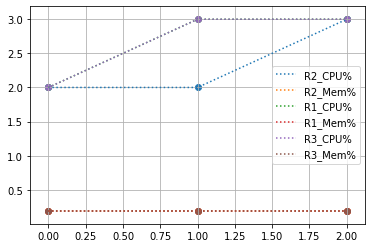

In [496]:
import matplotlib.pyplot as plt
import numpy as np

for host in ro_tseries.keys():
    y_cpu=ro_tseries[host]['cpu']
    y_mem=ro_tseries[host]['mem']
    x=np.arange(len(y_cpu))
    plt.scatter(x,y_cpu)
    plt.scatter(x,y_mem)
    
    plt.plot(x,y_cpu,':',label=host+'_CPU%')
    plt.plot(x,y_mem,':',label=host+'_Mem%')

plt.grid(True)
plt.legend()
plt.show()

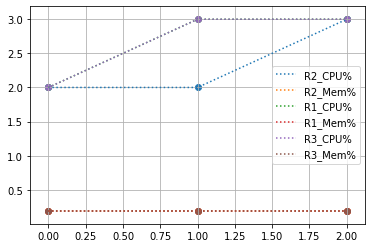

In [497]:
def plot_me():
    ro_tseries={}

    for host in list(dataset['hostname'].unique()):
        ro_tseries[host]={'cpu':[] , 'mem':[]}

    for host in list(dataset['hostname'].unique()):
        ro_tseries[host]['cpu']=dataset.loc[dataset['hostname'] == host]['cpu'].tolist()
        ro_tseries[host]['mem']=dataset.loc[dataset['hostname'] == host]['mem'].tolist()

    for host in ro_tseries.keys():
        y_cpu=ro_tseries[host]['cpu']
        y_mem=ro_tseries[host]['mem']
        x=np.arange(len(y_cpu))
        plt.scatter(x,y_cpu)
        plt.scatter(x,y_mem)

        plt.plot(x,y_cpu,':',label=host+'_CPU%')
        plt.plot(x,y_mem,':',label=host+'_Mem%')

    plt.grid(True)
    plt.legend()
    plt.show()

plot_me()

# Prediction with Machine Learning Models

## Dataset 

In [493]:
ds_list=[]
for host in list(dataset['hostname'].unique()):
    ds_list.append(dataset.loc[dataset['hostname'] == host])

In [494]:
for ds in ds_list:
    print('\n')
    print(ds)



    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
0  1564254356       R2  2.0  0.19        156093.75   482017.5   482017.5   
4  1564254370       R2  2.0  0.19        156093.75   482017.5   482017.5   
6  1564254381       R2  3.0  0.19        156093.75   482017.5   482017.5   

     Loopback0  
0  624375000.0  
4  624375000.0  
6  624375000.0  


    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
1  1564254356       R1  2.0  0.19        156093.75   482017.5   482017.5   
3  1564254370       R1  3.0  0.19        156093.75   482017.5   482017.5   
7  1564254381       R1  3.0  0.19        156093.75   482017.5   482017.5   

     Loopback0  
1  624375000.0  
3  624375000.0  
7  624375000.0  


    timestamp hostname  cpu   mem  FastEthernet0/0  Serial1/0  Serial1/1  \
2  1564254356       R3  2.0  0.19        156093.75   482017.5   482017.5   
5  1564254370       R3  3.0  0.19        156093.75   482017.5   482017.5   
8  1564254381       